In [ ]:
# link & mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libs
import pandas as pd

**Load in data**

#### Old con dataframe

In [ ]:
# import pre-processed data from google drive and store in dataframe using pandas function
# split the dataset into 6 different datasets, one for each class
# GAN model will generate samples for one class at a time, therefore dataframe needs to be split by class. Will be joined again after all samples have been generated.

d_Botnet = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/35/d_Botnet35.csv')

**Drop label category from each dataframe**

In [ ]:
#colonna superflua perché tanto ho già diviso per classi... la label di ogni df è uguale obv

dfBotnet = d_Botnet.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)

In [ ]:
df = dfBotnet

In [ ]:
df.shape

(736, 35)

In [ ]:
pd.options.display.float_format = '{:,.20f}'.format

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```


## **Define model architecture**

In [ ]:
# model architecture adapted from https://github.com/ydataai/ydata-synthetic - a model for generating credit card data
# modello GAN
# import os
import numpy as np

# Check that imports for the rest of the file work.
import tensorflow as tf
import tensorflow.compat.v1 as tfv1
import matplotlib.pyplot as plt
# Allow matplotlib images to render immediately.
%matplotlib inline
tfv1.logging.set_verbosity(tfv1.logging.ERROR)  # Disable noisy outputs.


from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model


In [ ]:
import matplotlib.pyplot as pyplot

#PLOTTINO
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
 # plot loss
 pyplot.subplot(2, 1, 1)
 pyplot.plot(d1_hist, label='d-loss-real')
 pyplot.plot(d2_hist, label='d-loss-fake')
 pyplot.plot(g_hist, label='g-loss')
 pyplot.legend()
 # plot discriminator accuracy
 pyplot.subplot(2, 1, 2)
 pyplot.plot(a1_hist, label='acc-real')
 pyplot.plot(a2_hist, label='acc-fake')
 pyplot.legend()

 pyplot.show()

In [ ]:
#classe del modello intero GAN
class GAN():
  def print_architecture(self):
        print("Generator Architecture:")
        self.generator.summary()

        print("\nDiscriminator Architecture:")
        self.discriminator.summary()

        print("\nCombined Model Architecture:")
        self.combined.summary()


    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        #optimizer
        optimizer = tf.keras.optimizers.legacy.Adam(lr, 0.5)


        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates samples
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model only the generator is trained
        self.discriminator.trainable = False

        # The discriminator takes generated samples as input and determines validity
        validity = self.discriminator(record)

        # The combined model
        # Trains the generator to try and create samples that will fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))

    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments

        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()

        for epoch in range(epochs):
            # Discriminator
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new samples
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real, d_acc1 = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake, d_acc2 = self.discriminator.train_on_batch(gen_data, fake)
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Generator
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            #Therefore, using the loss values directly is not recommended in GANs.
            #Instead, metrics such as the Inception Score, Frechet Inception Distance (FID score),
            #and perceptual similarity measures (LPIPS) are used for interpreting the results.
            #PERFORMANCE
            d1_hist.append(d_loss_real)
            d2_hist.append(d_loss_fake)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)
            # Plot the progress
            #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            print('==>> %d, dRLoss=%.3f, dFLoss=%.3f gLoss=%.3f, accR=%d, accF=%d' % (epoch, d_loss_real, d_loss_fake, g_loss, int(100*d_acc1), int(100*d_acc2)))
        plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)



#Singola classe del G
class Generator():
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim, data_dim):
        input_layer = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input_layer)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        # Use sigmoid activation in the output layer to constrain values to [0, 1]
        output_layer = Dense(data_dim, activation='sigmoid')(x)
        return Model(inputs=input_layer, outputs=output_layer)


#Singola classe del D
class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size

    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

**Generating class data**

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```




```
Given that your original data has 35 features
--> you might want to experiment with sizes around 35 or slightly larger <--
to ensure that the input noise vector captures additional variations while respecting the underlying structure of the data
```



In [ ]:
#Define model params and training params
# set up dataframe for input into model

data_columns = df.columns
df[data_columns] = df[data_columns]

# set generator parametes
batch_size = 1024 #@param
learning_rate=0.0001 #@param
input_noise = 16  #@param

input_shape=35 #numeroFeatures
dim=128 #@param

# set training parameters
epochs = 3000 #@param
log_step = 100

In [ ]:
# assign to variable
generator_parameters = [batch_size, learning_rate, input_noise, input_shape, dim]
training_parameters = ['', epochs, log_step]

Output streaming troncato alle ultime 5000 righe.
32/32 [==============================] - 0s 1ms/step
==>> 500, dRLoss=0.427, dFLoss=0.493 gLoss=1.444, accR=99, accF=78
32/32 [==============================] - 0s 1ms/step
==>> 501, dRLoss=0.429, dFLoss=0.473 gLoss=1.543, accR=99, accF=78
32/32 [==============================] - 0s 1ms/step
==>> 502, dRLoss=0.486, dFLoss=0.453 gLoss=1.508, accR=96, accF=83
32/32 [==============================] - 0s 1ms/step
==>> 503, dRLoss=0.441, dFLoss=0.420 gLoss=1.623, accR=99, accF=87
32/32 [==============================] - 0s 1ms/step
==>> 504, dRLoss=0.427, dFLoss=0.522 gLoss=1.462, accR=99, accF=72
32/32 [==============================] - 0s 1ms/step
==>> 505, dRLoss=0.484, dFLoss=0.400 gLoss=1.647, accR=95, accF=83
32/32 [==============================] - 0s 1ms/step
==>> 506, dRLoss=0.447, dFLoss=0.395 gLoss=1.690, accR=98, accF=87
32/32 [==============================] - 0s 1ms/step
==>> 507, dRLoss=0.421, dFLoss=0.266 gLoss=1.972, accR=99

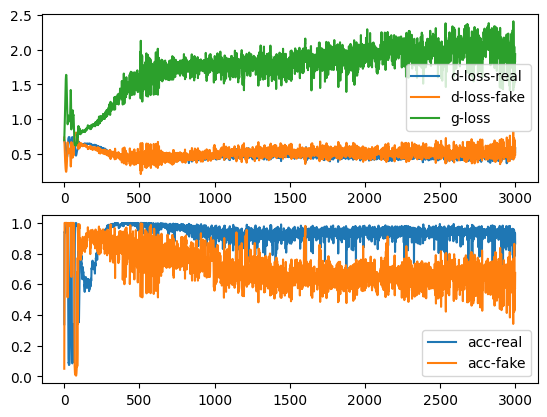

In [ ]:
# training
synthesizer = GAN(generator_parameters)
synthesizer.print_architecture()
# change passed in dataframe to select which class is to be generated
synthesizer.train(df, training_parameters)

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

In [ ]:
np.random.seed(3) # used for retestability

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#noise = np.random.normal(0,1, (1170495, 32)) # number of benign samples to be generated
#noise = np.random.normal(0,1, (70302, 32)) # number of dos hulk samples to be generated
#noise = np.random.normal(0,1, (2922, 32)) # number of ssh patator samples to be generated
#noise = np.random.normal(0,1, (2332, 32)) # number of dos slow loris samples to be generated
#noise = np.random.normal(0,1, (11, 32)) # number of heartbleed samples to be generated
noise = np.random.normal(0,1, (736, input_noise)) # number of botnet samples to be generated

[model_name, with_class, generator_model] = models['GAN']

X = generator_model.predict(noise)

23/23 [==============================] - 0s 1ms/step


In [ ]:
# Create a dataframe with generated samples, so can be used for evaluation later
gen_samples = pd.DataFrame(X, columns=data_columns)

In [ ]:
#gen_benign_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_benign_samples.csv')
# gen_dosHulk_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_dosHulk_samples.csv')
# gen_sshPatator_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_sshPatator_samples.csv')
# gen_dosSlowloris_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_dosSlowloris_samples.csv')
# gen_heartbleed_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_heartbleed_samples.csv')
# gen_infiltration_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_infiltration_samples.csv')

In [ ]:
df.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
0,0.00059517501487930003,0.00952985313655499953,0.00024119236370999999,0.12330418593294570351,0.00001507351992797033,0.01553036907836040023,0.00056911792821139995,0.00004199553134229017,0.00781627719580980061,0.00655401945724520037,...,0.50140552432168172814,0.00012938038134279999,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00058202563537790004,0.00002800257623701380,0.00001563474117663153,0.45454545454545458583
1,0.00104414169277020010,0.00952985313655499953,0.00024845658615930001,0.12330418593294570351,0.00001538431415328931,0.01576250570687669911,0.00102344393530069992,0.00002393458691479384,0.00797743755036259966,0.00655401945724520037,...,0.50140552432168172814,0.00022698179030459999,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00103257612722890005,0.00001596194671902185,0.00001563474117663153,0.45454545454545458583
2,0.00077073335260160005,0.00952985313655499953,0.00024119236370999999,0.12330418593294570351,0.00001507351992797033,0.01553036907836040023,0.00074772665746070002,0.00003242795662797918,0.00781627719580980061,0.00655401945724520037,...,0.50140552432168172814,0.00016754522065160000,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00076020082988589996,0.00002162419314729319,0.00001563474117663153,0.45454545454545458583
3,0.00061930001548249998,0.00952985313655499953,0.00024299328552560001,0.12330418593294570351,0.00001515121848430008,0.01558824189976630060,0.00059676798950229998,0.00004035928138168117,0.00785656728444799994,0.00655401945724520037,...,0.50140552432168172814,0.00013462494439400000,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00060753399655789995,0.00002691174293903145,0.00001563474117663153,0.45454545454545458583
4,0.00052496667979080001,0.00952985313655499953,0.00024299328552560001,0.12330418593294570351,0.00001515121848430008,0.01558824189976630060,0.00050268444761709995,0.00004761298233431034,0.00785656728444799994,0.00655401945724520037,...,0.50140552432168172814,0.00011411770648759999,0.50204755210561702317,0.00000000000000000000,0.12500190737773708705,0.00361638818951700008,0.00051265055964349996,0.00003174754353381907,0.00001563474117663153,0.45454545454545458583


In [ ]:
gen_samples.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
0,0.00092736951773986220,0.00893643870949745178,0.00031018169829621911,0.12295220792293548584,0.00001984273148991633,0.01521189883351325989,0.00080184359103441238,0.00004183008422842249,0.00762533303350210190,0.00590101536363363266,...,0.51232886314392089844,0.00020725038484670222,0.50753277540206909180,0.00000027116379897052,0.12370476126670837402,0.00378915993496775627,0.00100589834619313478,0.00002139153366442770,0.00002577469604148064,0.46007207036018371582
1,0.00076501484727486968,0.00782845262438058853,0.00020944149582646787,0.12262798845767974854,0.00001234471801581094,0.01438136119395494461,0.00070590019458904862,0.00002971686444652732,0.00644037267193198204,0.00583332031965255737,...,0.51031225919723510742,0.00016697152750566602,0.50609236955642700195,0.00000015546670795175,0.12230311334133148193,0.00318870088085532188,0.00078466901322826743,0.00001532859096187167,0.00001714049540169071,0.45489224791526794434
2,0.00091166334459558129,0.00913675501942634583,0.00027702655643224716,0.12213637679815292358,0.00001819485623855144,0.01420930027961730957,0.00083173188613727689,0.00003795539669226855,0.00775101361796259880,0.00619409373030066490,...,0.50977301597595214844,0.00019986991537734866,0.50464355945587158203,0.00000022966322887896,0.12301685661077499390,0.00375476130284368992,0.00085135543486103415,0.00001978759064513724,0.00002296183811267838,0.45388165116310119629
3,0.00081084191333502531,0.00836831610649824142,0.00023405904357787222,0.11990948021411895752,0.00001039161816152046,0.01483923848718404770,0.00066919293021783233,0.00002894158933486324,0.00661562476307153702,0.00578886270523071289,...,0.50836235284805297852,0.00015707893180660903,0.50631386041641235352,0.00000014485232213701,0.12128579616546630859,0.00303324335254728794,0.00071969517739489675,0.00001338161018793471,0.00001674368286330719,0.45186391472816467285
4,0.00079212425043806434,0.00864998623728752136,0.00025922767235897481,0.12193235009908676147,0.00001501049882790539,0.01448055449873209000,0.00072026089765131474,0.00003405805910006166,0.00685902126133441925,0.00595721602439880371,...,0.50292634963989257812,0.00017365222447551787,0.50142294168472290039,0.00000022181612280292,0.12362845242023468018,0.00333198206499218941,0.00085407862206920981,0.00001578864248585887,0.00001987287942029070,0.44718647003173828125


#Valutazione

In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'synthetic Data')

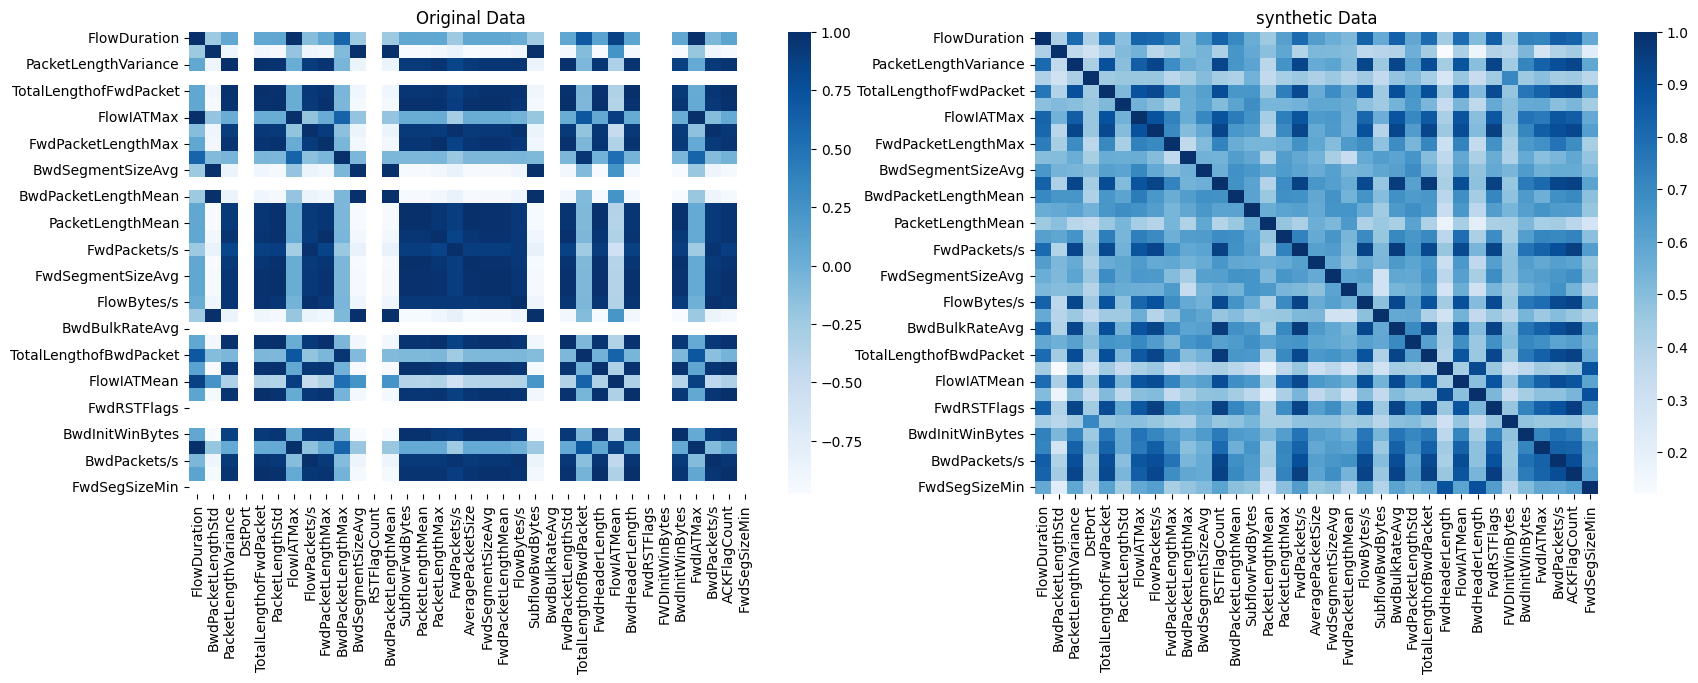

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(df.corr(), annot=False, ax=ax[0], cmap="Blues")
sns.heatmap(gen_samples.corr(), annot=False, ax=ax[1], cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

In [ ]:
real_data = df.to_numpy()
generated_data = gen_samples.to_numpy()

In [ ]:
from scipy.stats import wasserstein_distance

# Flatten the arrays for 1D distribution
real_flat = real_data.flatten()
generated_flat = generated_data.flatten()

# Compute Wasserstein distance
w_distance = wasserstein_distance(real_flat, generated_flat)

print('Wasserstein Distance final:', w_distance)

Wasserstein Distance final: 0.010980318390448543




```
Interpretation can depend on the scale and nature of your data, but in general:
## Closer to 0: Indicates a smaller difference between distributions.
```



In [ ]:
real = df['FlowDuration'].to_numpy()
gen = gen_samples['FlowDuration'].to_numpy()

w_dist_feature = wasserstein_distance(real, gen)
print("Wasserstein Distance for FlowDuration feature:", w_dist_feature)

Wasserstein Distance for FlowDuration feature: 0.0002663208801954511




```
# Wasserstein Distance for BwdPacketLengthStd feature: 0.0008046525194385199
# Wasserstein Distance for FlowDuration feature: 0.0003101878491190463
# Wasserstein Distance for PacketLengthVariance feature: 0.023556970948095415
# Wasserstein Distance for DstPort feature: 0.0016220070848744499
```



In [ ]:
# Choose the column you want to check
# 0 = FlowDuration
# 1 = BwdPacketLengthStd
# 2 = PacketLengthVariance
# 3 = DstPort

In [ ]:
from scipy.stats import ks_2samp


column_to_check = 0

# Perform the KS test for the selected column
ks_statistic, ks_p_value = ks_2samp(real_data[:, column_to_check], generated_data[:, column_to_check])

# Print the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

# Interpret the results
#A higher alpha means you are more lenient in terms of what level of evidence you require to reject the null hypothesis.
alpha = 0.1  # significance level
if ks_p_value > alpha:
    print("The distributions are similar (fail to reject the null hypothesis)")
else:
    print("The distributions are different (reject the null hypothesis)")

KS Statistic: 0.5855978260869565
P-value: 2.8390551908016695e-117
The distributions are different (reject the null hypothesis)


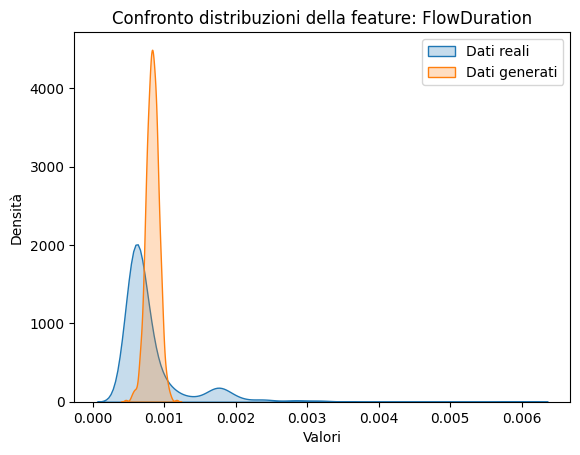

In [ ]:
column_to_compare = 0 #31

# Extract the selected column for each array
real_column = real_data[:, column_to_compare]
generated_column = generated_data[:, column_to_compare]

# Plot the KDE for both distributions
sns.kdeplot(real_column, label='Dati reali', fill=True)
sns.kdeplot(generated_column, label='Dati generati', fill=True)

# Add labels and legend
plt.title(f'Confronto distribuzioni della feature: {df.columns[column_to_compare]}')
plt.xlabel('Valori')
plt.ylabel('Densità')
plt.legend()
#salva in Drive
#images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf'
#plt.savefig(f"{images_dir}/distributionFeatureFlowDuration_genWGAN_t2.pdf", dpi=200, format='pdf') ###!!!!!!!!!!!!!! CAMBIARE TENTATIVI CON N°
plt.show()

In [ ]:
mse_value = tf.keras.losses.mean_squared_error(df['FlowDuration'], gen_samples['FlowDuration'])
print(f'Mean Squared Error: {mse_value}')

#deve essere basso

Mean Squared Error: 2.5021751071108156e-07




```
# 0 --> Mean Squared Error: 2.803826646413654e-07
# 1 --> Mean Squared Error: 3.4297804631933104e-06
# 2 --> Mean Squared Error: 0.011631663888692856
# 3 --> Mean Squared Error: 4.149306732870173e-06
```





```
Interpretation:

*   A smaller MSE indicates that the generated data is closer to the real data in terms of the selected feature.
*  Closer to 0 suggests better performance for that specific feature.


```



In [ ]:
def gaussian_kernel(x, y, sigma=1.0):
    # Gaussian kernel function
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * (sigma ** 2)))

def mmd(real_data, generated_data, kernel=gaussian_kernel):
    m = len(real_data)
    n = len(generated_data)

    # Compute the MMD statistic
    mmd_statistic = 0.0
    for i in range(m):
        for j in range(m):
            mmd_statistic += kernel(real_data[i], real_data[j])

    for i in range(n):
        for j in range(n):
            mmd_statistic += kernel(generated_data[i], generated_data[j])

    for i in range(m):
        for j in range(n):
            mmd_statistic -= 2 * kernel(real_data[i], generated_data[j])

    mmd_statistic /= (m * (m - 1)) + (n * (n - 1)) - 2 * m * n
    return mmd_statistic


mmd_statistic = mmd(real_data[:, 0], generated_data[:, 0])

print("MMD Statistic:", mmd_statistic)

MMD Statistic: -5.399429662164677e-08




```
you would want the MMD to be close to zero, as it implies that the generated samples are very similar to the real data.

Negative MMD: The MMD itself doesn't have a fixed sign, so negative values are not uncommon. The magnitude is more important,
and in this case, the small magnitude indicates similarity.
```



#Vecchi metodi valutazione

In [ ]:
#CONFRONTO TRA DISTRIBUZIONI

In [ ]:
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.7 MB/s eta 0:00:00


In [ ]:
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic

In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

quality_report = evaluate_quality(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 595/595 [00:43<00:00, 13.60it/s]

Overall Score: 43.44%

Properties:
- Column Shapes: 33.76%
- Column Pair Trends: 53.12%


In [ ]:
diagnostic_report = run_diagnostic(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 257.46it/s]

Overall Score: 82.76%

Properties:
- Data Validity: 65.52%
- Data Structure: 100.0%


Text(0.5, 1.0, 'synthetic Data')

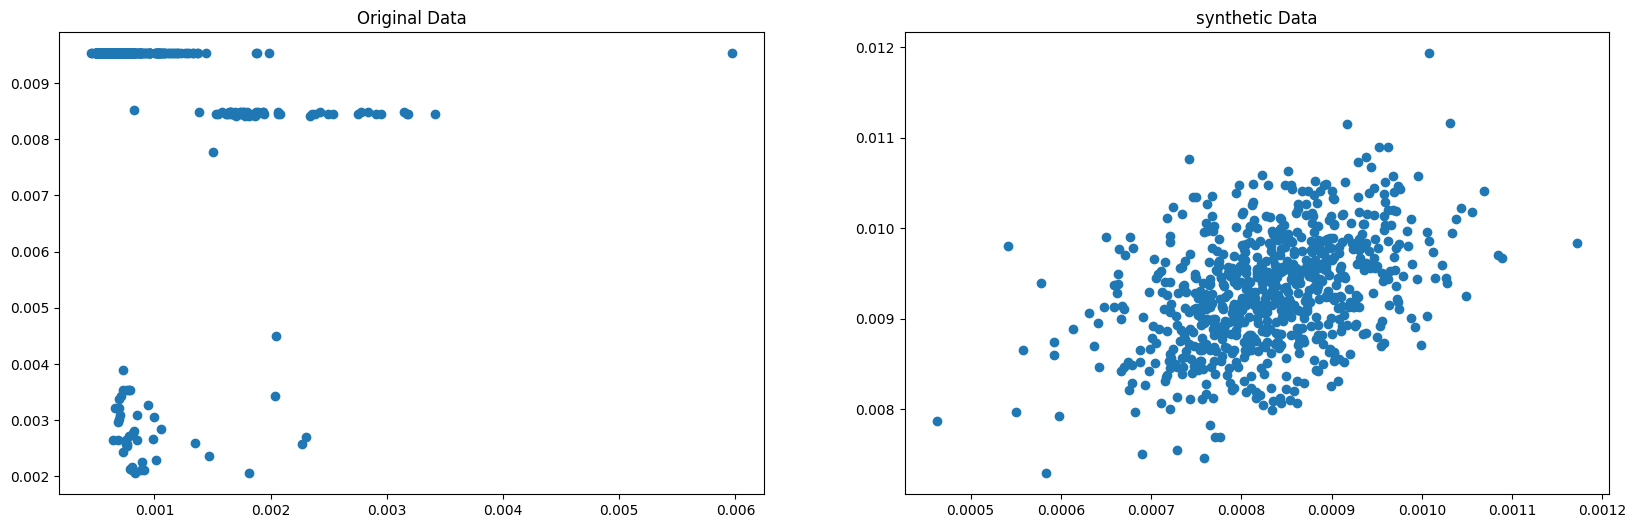

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(df.iloc[:, 0], df.iloc[:, 1])
ax[1].scatter(gen_samples.iloc[:, 0], gen_samples.iloc[:, 1])
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")